# Near-Surface Air Temperature

## Test analyse 'tas' en multimodèle avec Intake en local
Environnement `scipyconf2020_xesmf`

```bash
conda create --name myenv --file scipyconf2020_xesmf.txt  
```

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import intake
from dask.distributed import Client

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()
client = Client()
client

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) 
[GCC 7.5.0]
Virtual memory usage - total: 31 GB / available: 23 GB / percent used: 25.4 %


Client Scheduler: tcp://127.0.0.1:45711 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 33.33 GB


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

var = 'tas'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [4]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('~/data/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim, lon=lonlim).tmp
obs_clim = u.clim(obs, calendar=obs.time.encoding['calendar'])
# obs_clim.plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [5]:
regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_clim_regrid = regridder(obs_clim)

Reuse existing file: bilinear_50x100_25x50.nc


## Check models

In [7]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

In [9]:
cat = col.search(
    experiment_id="historical",
#     table_id="Amon",
    variable_id=["tas","snc","pr"],
#     grid_label="gn",
)

cat

,unique
activity_id,1
institution_id,29
source_id,53
experiment_id,1
member_id,176
table_id,4
variable_id,3
grid_label,4
zstore,1677
dcpp_init_year,0


In [10]:
cat.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,1,2,2
ACCESS-ESM1-5,1,2,2
AWI-CM-1-1-MR,1,2,2
AWI-ESM-1-1-LR,1,2,2
BCC-CSM2-MR,1,3,4
BCC-ESM1,1,3,3
CAMS-CSM1-0,1,2,1
CAS-ESM2-0,1,2,1
CESM2,1,3,3


### Get only the models that have the 3 variables 
https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html#Enhanced-search:-enforce-query-criteria-via-require_all_on-argument

In [11]:
# Define our query
query = dict(
    experiment_id="historical",
    variable_id=["tas","snc","pr"],
)

In [13]:
col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id", "member_id"]
].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
BCC-CSM2-MR,1,3,4,3
BCC-ESM1,1,3,3,3
CESM2,1,3,3,11
CESM2-WACCM,1,3,3,3
CNRM-CM6-1,1,3,4,30
CNRM-ESM2-1,1,3,4,11
CanESM5,1,3,3,50
EC-Earth3-Veg,1,3,3,6
GFDL-CM4,1,3,4,1


## Load models

In [20]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

list_models = u.get_model_names()

bias = []

for model in list_models[:2]:
    print(model)
    institute, grid, realization = u.get_model_infos(model, var)
    
    # Intake
    cat = col.search(experiment_id=["historical"], table_id=table, variable_id=var, source_id=model, member_id=realization, grid_label=grid)
    data_source = cat[cat.keys()[0]]
    ds = data_source(zarr_kwargs={'consolidated': True, 'decode_times': True}).to_dask()
    
    model_clim = ds.sel(time=period, 
          lat=slice(latlim.start-5, latlim.stop+5), # Add 5° for the regrid
          lon=slice(lonlim.start-5, lonlim.stop+5))[var].mean('time').squeeze().load() - 273.15
    
    # Regrid towards elevation grid 1°x1°
    regridder = xe.Regridder(model_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
    model_clim_regrid = regridder(model_clim)
    
    bias.append(model_clim_regrid - obs_clim_regrid)

BCC-CSM2-MR
Reuse existing file: bilinear_32x54_25x50.nc
BCC-ESM1
Reuse existing file: bilinear_13x21_25x50.nc


/home/lalandmi/miniconda3/envs/scipyconf2020_xesmf/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.linewidth' was renamed to grid.linewidth in version 0.6.
/home/lalandmi/miniconda3/envs/scipyconf2020_xesmf/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.color' was renamed to grid.color in version 0.6.
/home/lalandmi/miniconda3/envs/scipyconf2020_xesmf/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.alpha' was renamed to grid.alpha in version 0.6.
/home/lalandmi/miniconda3/envs/scipyconf2020_xesmf/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.linewidth' was renamed to grid.linewidth in version 0.6.
/home/lalandmi/miniconda3/envs/scipyconf2020_xesmf/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.color' was renamed to grid.color in version 0.6.
/home/lalandmi/miniconda3/envs/scipyconf2020_xesm

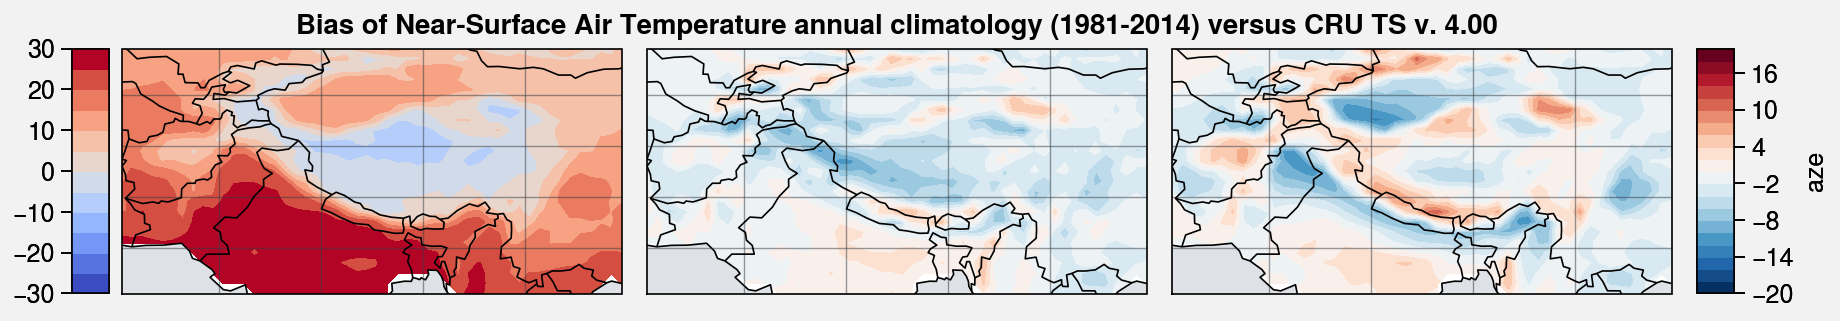

In [38]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1)

for i, ax in enumerate(axs):
    if i == 0:
        axs[i].contourf(obs_clim_regrid, cmap=cmap, levels=levels, colorbar='l')
    else:
        #Plot
        m = axs[i].contourf(bias[i-1], cmap='RdBu_r', levels=plot.arange(-20,20,2))

        # Compute RMSE
    #     rmse = np.sqrt((bias[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))**2).mean().values)

    #     axs[i].format(
    #         title=list_models[i],
    #         lltitle='RMSE = '+str(round(rmse,1)) +' °C'
    #     )
    
    
f.colorbar(m, label='aze', loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Bias of Near-Surface Air Temperature annual climatology (1981-2014) versus "+obs_longname,
    lonlines=10, latlines=5, abc=False,
    latlim=(elevation.lat.min().values, elevation.lat.max().values), 
    lonlim=(elevation.lon.min().values, elevation.lon.max().values)
)

# f.save('img/'+var+'_bias_multimodel.jpg')
# f.save('img/'+var+'_bias_multimodel.png')
# f.save('img/'+var+'_bias_multimodel.pdf')